In [2]:
from astropy.time import Time
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates
import numpy as np


# Simulate ZTF cadence and error curve 

ZTF does g and r every three nights , errors a bit worse than LSST. We expecta basically observations for the majority of 2018 to be released in May 2019. 

1 year, two filters (g,r) once every three nights  - total  about 2*365/3 = 240 epochs. 

In [ ]:
start_date = Time(['2018-01-01T00:00:00.000'],format='isot')

mjd_ztf = []
for i in range(120) : 
    obs1 = start_date.mjd[0] + 3*i # every third day .... 
    obs2 = obs1  + (30/(24*60))  # add 30 mins between g and r 
    # http://faculty.washington.edu/ecbellm/docs/The_Zwicky_Transient_Facility_Surveys_and_Scheduler.pdf
    mjd_ztf.append(obs1)
    mjd_ztf.append(obs2)
    
# Note : I'm not distinguishing between g or r - assuming that with the real ZTF data 
# we would combine the two filters, and use all that together 
# in the master SDSS r-band light curve 
np.savetxt('../dp2/mjd_ztf_2018_240_epochs.txt',mjd_ztf, )

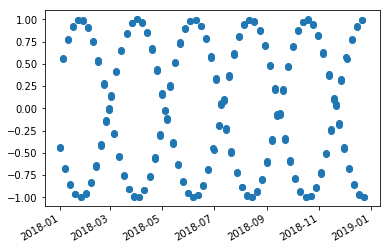

In [9]:
%matplotlib inline
# Show that it worked ... 
mags = np.sin(np.array(mjd_ztf))
fig,ax = plt.subplots()
date = Time(np.array(mjd_ztf), format='mjd')
plt.plot_date(date.datetime, mags)
ax.fmt_xdata = mdates.DateFormatter('%Y-%m-%d')
fig.autofmt_xdate()

In [10]:
len(mjd_ztf)

240

For errors, just assume (before there's something better) they are 50% worse than LSST... 

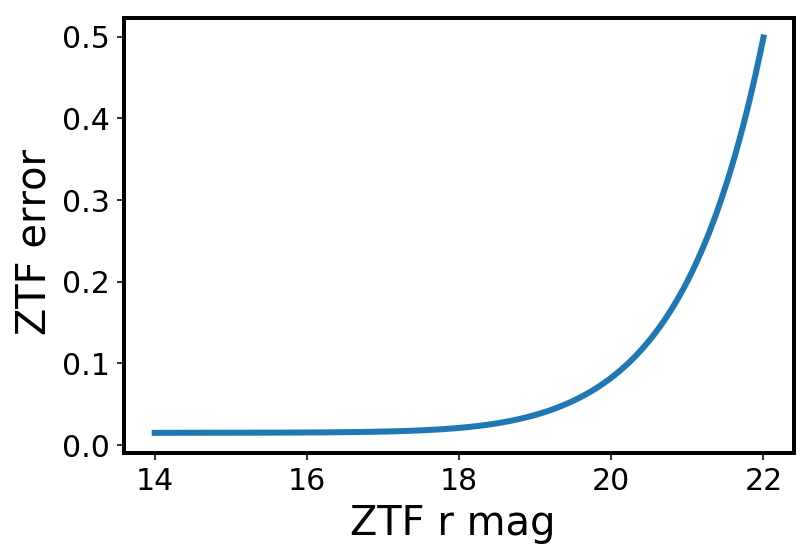

In [5]:
%matplotlib inline

def calc_ztf_error(m, gamma=0.05, sigma_sys=0.015, m5=21):
    # Calculate ZTF error based on magnitude ,
    # using the LSST error curve 
    # We adjusted m5 and sigma_sys to match the 
    # ZTF best mag rms from ZTF light curves 
    # The LSST formula is a magnitude-dependent single-visit 
    # formula for r-band from 
    # https://www.lsst.org/sites/default/files/docs/sciencebook/SB_3.pdf
    # https://www.lsst.org/scientists/scibook
    # https://arxiv.org/abs/0912.0201
    # See Chap.3, Sec. 3.5, Eq. 3.1, Table. 3.2
    #sigma_sys = 0.015
    #gamma = 0.05
    #m5 = 21
    x = np.power(10,0.4 * (m-m5))
    sigma_rand = np.sqrt(  (0.04-gamma) * x + gamma * x*x ) 
    sigma = np.sqrt(sigma_sys**2.0 + sigma_rand**2.0)
    return sigma

# Illustrate 
# Plot the error curve 
m = np.linspace(14,22,1000)
e = calc_ztf_error(m, 0.039, 0.015, 21)
plt.plot(m,e, lw=3)
plt.xlabel('ZTF r mag ')
plt.ylabel('ZTF error ')
plt.savefig('ZTF_error_curve_grband_fake.png', bbox_inches='tight')

Note: based  on the ZTF error curve , plotting `bestmedianmag` vs `bestmagrms`  for 10 000 light curves from `ztf_1am_lc` , one gets a much larger error : 
<img src='ZTF_1am_lc_g_error_curve.png' width=500></img>

This data was obtained on `epyc` with the following code snippet:
    
    from axs.catalog import AxsCatalog
    from axs.axsframe import AxsFrame
    from pyspark.sql.functions import array_contains
    from astropy.table import Table
    axs_catalog = AxsCatalog(spark)
    ztf_lc = axs_catalog.load("ztf_1am_lc")
    ztf_lc_fid = ztf_lc.select(['zone', 'dup', 'matchid', 'ra', 'dec', 
               'bestmagrms', 'bestmeanmag', 'bestmedianmag',
               'medianmag','meanmag','nbestobs', 'ngoodobs']).\
      where((ztf_lc['ngoodobs']>100) & (array_contains(ztf_lc['filterid'], 1))).\
    limit(10000).toPandas()
    
    ztf_table = Table.from_pandas(ztf_lc_fid)
    ztf_table.write('ztf_1am_lc_ngoodobs_gt_100_filterid_1_limit10000.txt',
                format='ascii')

In [3]:
# Get the 10 000 ZTF objects that were used to make the above figure : 
from astropy.table import Table
ztf = Table.read('ztf_1am_lc_ngoodobs_gt_100_filterid_1_limit10000.txt', format='ascii')

In [28]:
sns.color_palette?

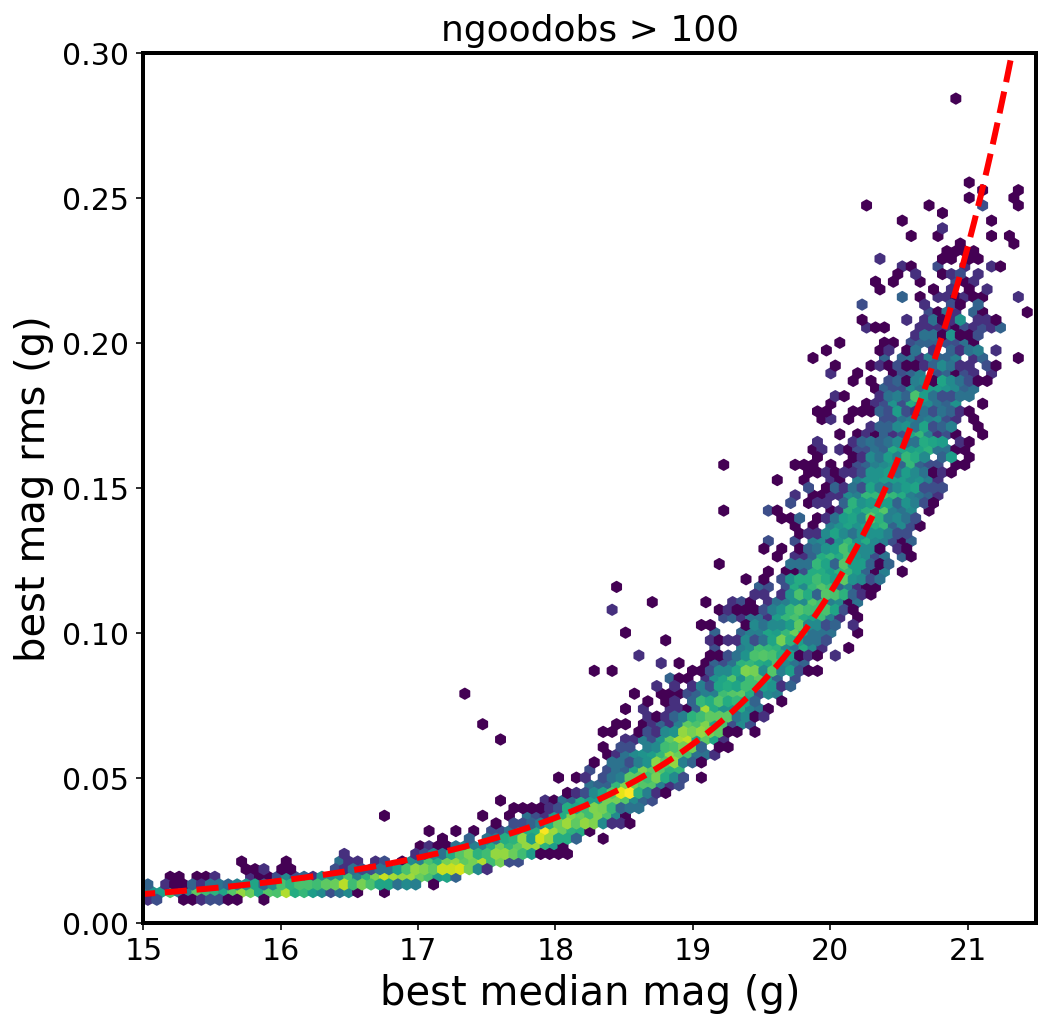

In [55]:
import matplotlib.pyplot as plt 
%matplotlib inline
%config InlineBackend.figure_format='retina'
import seaborn as sns 
import matplotlib.lines as mlines
from matplotlib import rcParams 
rcParams['ytick.labelsize'] = 15
rcParams['xtick.labelsize'] = 15
rcParams['axes.labelsize'] = 20
rcParams['axes.linewidth'] = 2
rcParams['font.size'] = 15
rcParams['axes.titlesize'] = 18
# magnitude scatter can serve as  a proxy for photometric noise ... 
fig,ax = plt.subplots(1,1, figsize=(8,8))
x,y = ztf['bestmedianmag'],ztf['bestmagrms']
xmax =21.5
ax.hexbin(x,y , extent=(15,xmax,0,0.3), mincnt=2, bins='log')
#ax.plot(x, calc_lsst_error(x))
ax.set_xlim(15,xmax)
# I can use that because I can't find the photometric noise model... 
ax.set_xlabel('best median mag (g)')
ax.set_ylabel('best mag rms (g)')
ax.set_title('ngoodobs > 100')

xspace = np.linspace(14,xmax,1000)
current_palette = sns.color_palette(n_colors=21)


ax_legend_handles = []

gamma = 0.025 
sigma_sys = 0.015
m5 = 20.75
#for gamma in np.linspace(0.01,0.04, 3) :
#for sigma_sys in np.linspace(0.001, 0.017, 10):
#for m5 in np.linspace(20,21.5,5):
   # e = calc_ztf_error(m, gamma=0.025, sigma_sys = 0.015, m5 = 20.75)
   # ax.plot(m,e, lw=3,  color=current_palette[i])
   # line = mlines.Line2D([], [], color=current_palette[i],label=str(m5) )
    #ax_legend_handles.append(line)
    #i += 1 
#ax.legend(loc='upper left', handles = ax_legend_handles,
#                bbox_to_anchor=(0.02, 0.9), fontsize=15,fancybox=True)


# s1 = r'$x = 10^{0.4  (m-m5)}$'
# s2 = r'$\sigma_{\mathrm{sys}} = 0.005, m_{5} = 20.8 , \gamma = 0.025$'
# s3 = r'$\sigma_{\mathrm{rand}} = \sqrt{  (0.04-\gamma) x + \gamma x^{2}  }$'
# s4=  r'$\sigma = \sqrt{\sigma_{\mathrm{sys}}^{2} + \sigma_{\mathrm{rand}}^{2}}$'
# s = s1+'\n'+s2+'\n'+s3+'\n'+s4
# ax.text(16,0.3, s, fontsize=17)

# 0.025
# for g in np.linspace(0.02,0.025,5):
#     e = calc_ztf_error(xspace, gamma=g, sigma_sys = 0.006, m5 = 20.9)
#     ax.plot(xspace,e, lw=3,   ls='--', label=g)
# 0.05
# for s in np.linspace(0.001,0.005,5):
#     e = calc_ztf_error(xspace, gamma=0.025, sigma_sys = s, m5 = 20.9)
#     ax.plot(xspace,e, lw=3,   ls='--', label=g)
# 20.8
# for m in np.linspace(20.5,20.8,5):
#     e = calc_ztf_error(xspace, gamma=0.025, sigma_sys = 0.005, m5 = m)
#     ax.plot(xspace,e, lw=3,   ls='--', label=g)

e = calc_ztf_error(xspace, gamma=0.025, sigma_sys = 0.005, m5 = 20.8)
ax.plot(xspace,e, lw=3,   ls='--',c = 'red',  label=g)  
ax.set_ylim(0,0.3)
#ax.legend()
#plt.legend()
#from scipy import optimize
# xmin,xmax,ymin,ymax = 15,21,0,0.3
# m = (xmin<x)*(x<xmax)*(ymin<y)*(y<ymax)
# p, cov = optimize.curve_fit(calc_ztf_error,x[m],y[m], 
#                             p0=[0.03,0.003,21],
#                            bounds=((0.001,0.001, 20), (0.1,0.5,23))
#                            )#, 24.7])
# print(p)
# e = calc_ztf_error(xspace,p[0],p[1],p[2])
# ax.plot(xspace,e, lw=3,  color='red', ls='--')

plt.savefig('ZTF_error_curve.png', bbox_inches='tight', dpi=100)

In [29]:
calc_ztf_error?

In [33]:


ax.plot(np.sort(x[m]), fit_polynomial(np.sort(x[m])

In [34]:
p

array([1.30872134e-02, 2.00000000e-03, 2.08597488e+01])

Ok, so using the LSST Formula, I find that the best -looking params are 
gamma = 0.025 ,   sigma_sys = 0.005,   m5 = 20.75  

In [30]:
params[1]

-1.1828391008935433

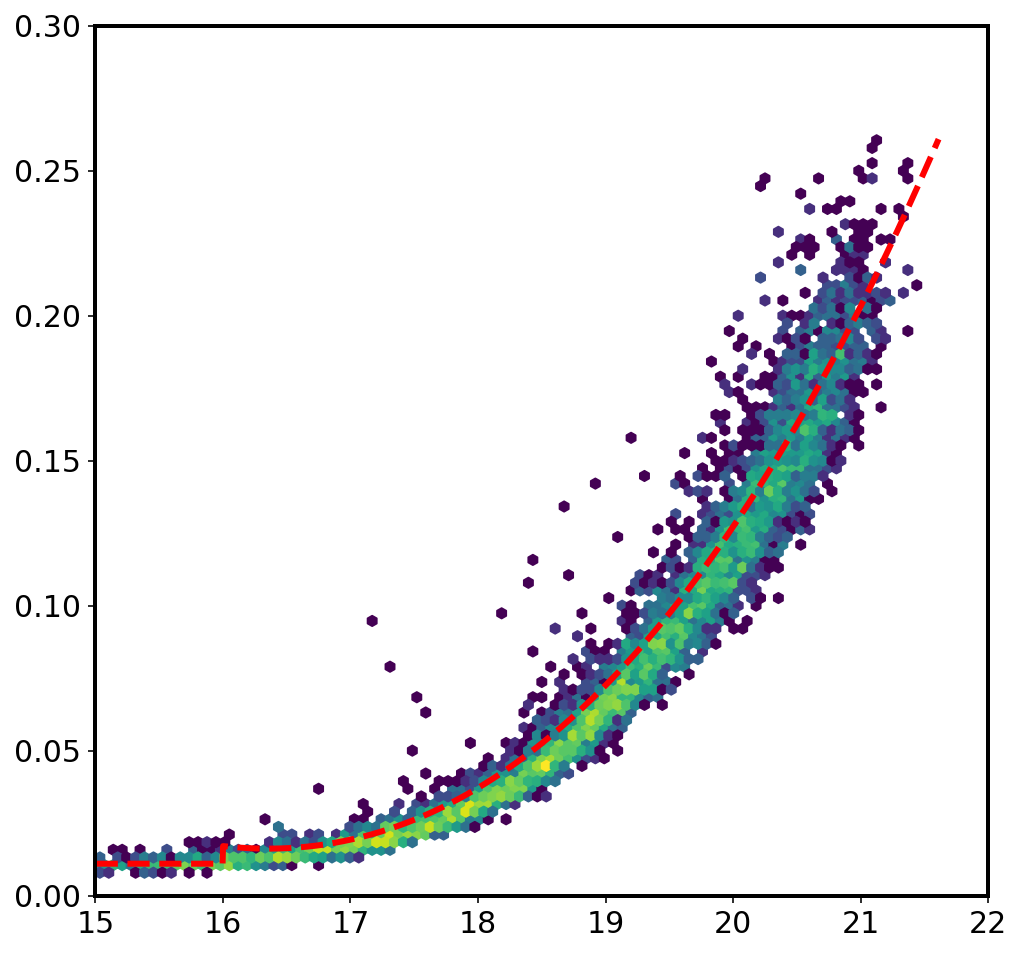

In [61]:
%matplotlib inline
fig,ax = plt.subplots(1,1, figsize=(8,8))
xmin,xmax,ymin,ymax = 15,22,0,0.3
x,y = ztf['bestmedianmag'].data.data , ztf['bestmagrms'].data.data
m = (xmin<x)*(x<xmax)*(ymin<y)*(y<ymax)
ax.hexbin(x,y , extent=(xmin,xmax,ymin,ymax ), mincnt=2, bins='log')


def fit_ztf_error(m,sigma_sys, gamma):#, m5 ):
    # fit ZTF error using the same functional form as LSST,
    # but keeping the parameters as free arguments ... 
    #sigma_sys = 0.005 # systemic error 
    #gamma = 0.039  
    m5 = 22.7 # 5 sigma depth 
    x = np.power(10,0.4 * (m-m5))
    # random error : 
    sigma_rand = np.sqrt(  (0.04-gamma) * x + gamma * x*x ) 
    # variance consists of systemic error and random error 
    # addded in quadrature 
    sigma = np.sqrt(sigma_sys**2.0 + sigma_rand**2.0)
    return sigma


def fit_polynomial(x,a,b,c,d):
    m1 =  x > 16
    y = x.copy()
    y[m1] = a*np.power(x[m1],3.0)+ b*np.power(x[m1],2.0) + c*x[m1]+ d
    y[~m1] = 0.011 #np.median(y[(15<x)*(x<16)])
    return y 

params, params_covariance = optimize.curve_fit(fit_polynomial,x[m],y[m], 
                                               p0=[1,1,1,1])#, 24.7])

ax.plot(np.sort(x[m]), fit_polynomial(np.sort(x[m]), params[0], params[1],params[2],
                                     params[3]), ls='--',lw=3,c='red',
         label='Fitted function')

This could be done even easier ( to avoid all sillyness of the step function above, etc.) : 
    just calculate the **median rms error in each magnitude bin** rather than fitting some 
    silly functionals. Save that as a lookup table, and use 
    np.interp1d to interpolate this smooth function:
    
    

In [108]:
len(bin_means)

42

/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/scipy/stats/_binned_statistic.py:621: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


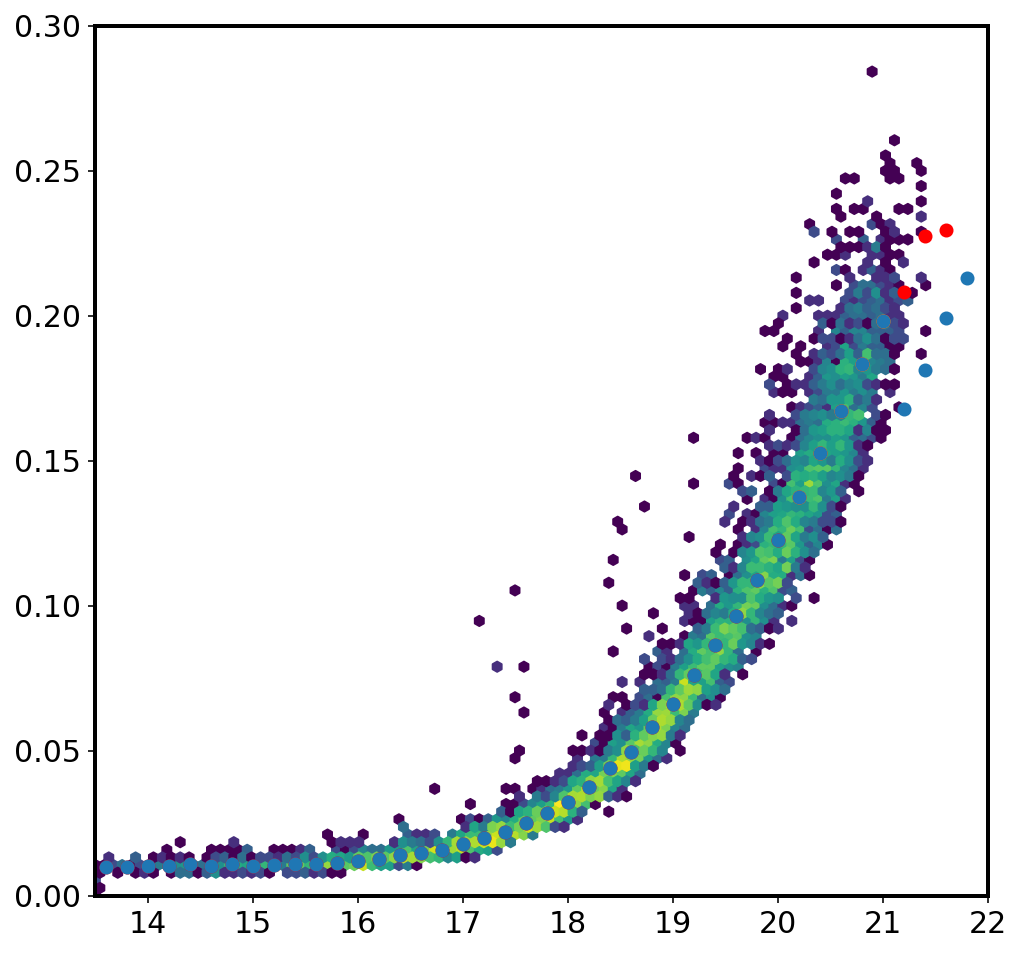

In [127]:
%matplotlib inline
fig,ax = plt.subplots(1,1, figsize=(8,8))
xmin,xmax,ymin,ymax = 13.5,22,0,0.3
x,y = ztf['bestmedianmag'].data.data , ztf['bestmagrms'].data.data
m = (xmin<x)*(x<xmax)*(ymin<y)*(y<ymax)
ax.hexbin(x,y , extent=(xmin,xmax,ymin,ymax ), mincnt=2, bins='log')
from scipy.stats import binned_statistic
bins  = np.arange(xmin,xmax,0.2)
bin_means, bin_edges, binnumber = binned_statistic(x[m], y[m], 
                  statistic='median', bins=bins)
bin_centers = (bin_edges[:-1]+bin_edges[1:])/2
plt.scatter(bin_centers, bin_means, c='red')

plt.scatter(bin_centers[-9:-4], bin_means[-9:-4], c='orange')
err = bin_means[:-4]
delta  = err[-4:]-err[-5:-1]
err2 = np.append(err, err[-4:] + delta)
plt.scatter(bin_centers, err2)

I get stuck  - it's a silly problem! 

But here projected ZTF mags do not reach as deep as the magnitudes of the combined light curves: 
    
    

In [95]:
import os 

# plot the distribution of SDSS magnitudes, PS1 magnitudes in combined light curves...
# combined real light curves 
realDir = '../data_products/Combined_LC/'
lightcurve_list =  os.listdir(realDir)

stats = {}
segs = ['sdss', 'ps1', ]
for seg in segs: 
    stats[seg] = {'lcname':[], 'medErr':[], 'meanErr':[],
                 'medMag':[], 'meanMag':[]}
for i in range(len(lightcurve_list)):
    if i % 500 == 0 : print(i)
    lcname = lightcurve_list[i]
    lc_real = Table.read(realDir+lcname, format='ascii')
    lc_real.rename_column('originSurvey', 'survey')

    #segs = np.unique(lc_real['survey'].data)
    for seg in segs:  
        lc = lc_real[lc_real['survey'] == seg]
        stats[seg]['lcname'].append(lcname)
        stats[seg]['medErr'].append(np.median(lc['magerr']))
        stats[seg]['meanErr'].append(np.mean(lc['magerr']))
        stats[seg]['medMag'].append(np.median(lc['mag']))
        stats[seg]['meanMag'].append(np.mean(lc['mag']))
    
fname = 'combined-r_band_sdss_ps1_stats'
np.save(fname, stats)

0


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:734: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


500
1000
1500
2000
2500
3000


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3115: RuntimeWarning: Mean of empty slice.
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


3500
4000
4500
5000
5500
6000


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


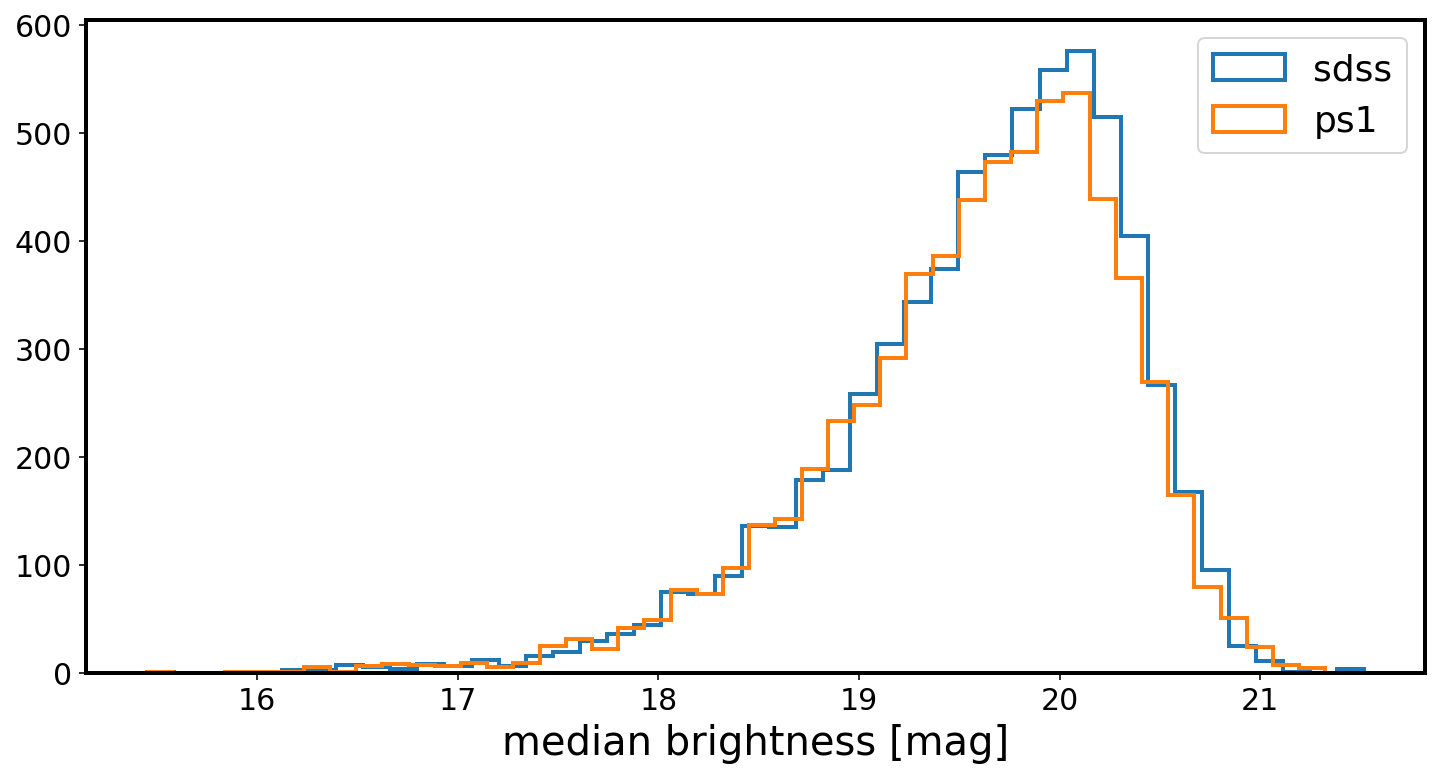

In [101]:
import pandas as pd
from astropy.table import join
fname = 'combined-r_band_sdss_ps1_stats.npy'
r = np.load(fname).item()
# convert a dict to a table, choosing relevant parts... 
seg = list(r.keys())

d1 = pd.DataFrame.from_dict(r[seg[0]])
t1 = Table.from_pandas(d1)

d2 = pd.DataFrame.from_dict(r[seg[1]])
t2 = Table.from_pandas(d2)

sall =  join(t1,t2, keys='lcname', table_names=[seg[0] ,seg[1]])

%matplotlib inline
fig,ax = plt.subplots(1,1,figsize=(12,6))
for seg in list(r.keys()):
    ax.hist(sall['medMag_'+seg], lw=2, label=seg, bins=45,
           histtype='step')
ax.legend(fontsize=18)
ax.set_xlabel('median brightness [mag]')
plt.savefig('combined-r_band_sdss_ps1_medMag.png', bbox_inches='tight')

Since that's the median, and $SF_{\infty}$ is 0.2 mag,  I'd expect that the faintest DRW in the simulation would be about 0.2 mag fainter than the faintest light curve above... I.e. about 22 mag.  So the ZTF error lookup table has to get to 22 mag, at the latest... 